<a href="https://colab.research.google.com/github/Koki-g/Bach_book/blob/main/Bach_book_Exercise_5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 5.5 Compute all constants for ℓ2-regularized logistic regression

### Code

In [1]:
import numpy as np
from scipy.special import expit

In [2]:
class LogisticRegression(object):
    """
    ロジスティック回帰分類器
    パラメータの説明
    ----------
    ・learning_rate : int or float, default=1.0
        勾配降下法で、損失関数の最小値に向かって移動する際の、各反復におけるステップサイズを決定する。
    ・max_iter : int, default=100
        最適化アルゴリズムが収束するまでに要する最大反復回数を決定する。 
    ・penalty : None or 'l2', default='l2'.
        L2正則化を行うかどうかのオプション。
    ・C : float, default=1.0
        正則化の強さの逆数で、値が小さいほど正則化が強くなる。
    ・tolerance : float, optional, default=1e-4
        勾配降下を終了させるエポック間の重みの変化量を示す値。
    """

    def __init__(self, learning_rate=1.0, max_iter=100, regularization='l2', C = 1.0, tolerance = 1e-4):
        self.learning_rate  = learning_rate
        self.max_iter       = int(max_iter)
        self.regularization = regularization
        self.C              = C
        self.tolerance      = tolerance
    
    def fit(self, X, y):
        """
        与えられた学習データに従ってモデルを適合させる。
        パラメータの説明
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            学習ベクトル。n_samples はサンプル数、n_features は特徴数である。
        y : array-like of shape (n_samples,)
            X に対応するターゲットベクトル。
        Returns
        -------
        self : object
        """
        self.theta = np.zeros(X.shape[1] + 1) # 重みθ(+1列はバイアス分)
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1) # 学習データX(先頭 +1列はバイアス分)

        for _ in range(self.max_iter): # 収束するor最大反復回数に達するまで繰り返す
            y_hat = self.__sigmoid(X @ self.theta) # Φ(Z)
            errors = y_hat - y # Φ - Y
            N = X.shape[0] # 学習データの数n

            if self.regularization is not None: # 正則化する場合
                delta_grad = self.learning_rate * ((X.T @ errors) + (np.sum(self.theta)/self.C)) # F'(θ) * N (まだNで割られていない)
            else: # 正則化しない場合
                delta_grad = self.learning_rate * (X.T @ errors)

            if np.all(abs(delta_grad) >= self.tolerance): # F(θ)'のすべての傾きがtolerance以上の場合、重みθを更新する(np.all関数は要素が全てTrueになるならTrueを返す)
                self.theta -= delta_grad / N
            else:
                print("Break!")
                break # 勾配にtolerance未満の傾きが含まれる場合、for文を抜け、更新を止める。

        self.get_constants(X, y_hat, N)

        return self

    def predict_proba(self, X):
        """
        Xのサンプルに対する確率推定値。
        パラメータの説明
        ----------
        X : array-like of shape (n_samples, n_features)
            n_samples` はサンプル数、 `n_features` は特徴量の数であり、評価の対象となるベクトル。
        Returns
        -------
        probs : array-like of shape (n_samples,)
            各サンプルの確率を返す．
        """
        return self.__sigmoid((X @ self.theta[1:]) + self.theta[0])
    
    def predict(self, X):
        """
        X のサンプルに対してクラスラベルを予測する。
        パラメータの説明
        ----------
        X : array_like or sparse matrix, shape (n_samples, n_features)
          サンプルデータ。
        Returns
        -------
        labels : array, shape [n_samples]
            サンプル毎の予測されたクラスラベル。
        """
        return np.round(self.predict_proba(X))
        
    def __sigmoid(self, z):
        """
        シグモイド関数
        パラメータの説明
        ------------
        z : float
            重みθとサンプルxの特徴の線形結合
            z = θ_0 + θ_1*x_1 + ... + θ_n*x_n
        Returns
        ---------
        z におけるロジスティック関数の値
        """
        return 1 / (1 + expit(-z))

    def get_params(self):
        """
        係数と切片をモデル化するためのメソッドを得る。
        Returns
        -------
        params : dict
        """
        try:
            params = dict()
            params['intercept'] = self.theta[0]
            params['coef'] = self.theta[1:]
            return params
        except:
            raise Exception('Fit the model first!')
    
    def get_constants(self, X, y_hat, N):
      """
      学習済みモデルを特徴づけるヘッセ行列Hの最大固有値L、最小固有値μ、両者から導かれる条件数κを計算する。
      パラメータの説明
      ------------
      X : array-like of shape (n_samples, n_features)
      y_hat : array-like of shape (n_samples,)
      N : int
          n_samples
      Returns
      -------
      None
      """
      from scipy.sparse.linalg import eigs
      J = np.ones(y_hat.shape)
      W = np.diag(y_hat * J)
      H = (X.T @ W @ X) / N
      L, vector = eigs(H, 1) # 最大固有値L # eigs:固有値のリスト(value)と、固有ベクトルを列に持つ行列のタプル(vector)が戻る
      print("L :", L)
      μ, vector = eigs(H, 1, which="SM") # 最小固有値μ
      print("μ :", μ)
      κ = L / μ # 条件数κ
      print("κ :", κ)
      return 

### Results
ダミーのデータセットに分類器をあてはめて、結果を確認する。

In [3]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,n_clusters_per_class=1)
# n_samples:サンプル数、n_features:特徴量の数、n_informative:目的変数のラベルと相関が強い特徴量の数、n_redundant:冗長特徴量の数、
# n_repeated:informativeとredundantからランダムに抽出された重複特徴量の個数、n_classes:分類クラス数、n_clusters_per_class:1クラスのクラスタ数, 
clf = LogisticRegression().fit(X, y)

L : [2.06014739+0.j]
μ : [0.23774865+0.j]
κ : [8.66523289+0.j]


判定境界のプロット

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as cma

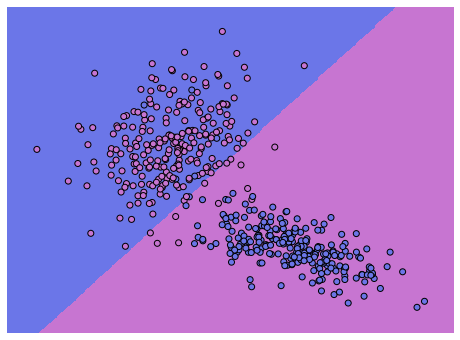

In [5]:
def plot_decision_boundary(X, y, model):
    cMap = cma.ListedColormap(["#6b76e8", "#c775d1"])
    cMapa = cma.ListedColormap(["#c775d1", "#6b76e8"])

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.column_stack((xx.ravel(), yy.ravel())))
    Z = Z.reshape(xx.shape)

    plt.figure(1, figsize=(8, 6), frameon=True)
    plt.axis('off')
    plt.pcolormesh(xx, yy, Z, cmap=cMap)
    plt.scatter(X[:, 0], X[:, 1], c=y, marker = "o", edgecolors='k', cmap=cMapa)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

plot_decision_boundary(X, y, clf)